In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import sqlite3

In [10]:
df = pd.DataFrame({
    'cycle': np.arange(1, 501),
    'sensor_1': np.random.normal(0, 1, 500),
    'sensor_2': np.random.normal(0, 1, 500),
    'time_to_failure': np.random.randint(1, 100, 500),
    'failure': np.random.randint(0, 2, 500)
})

conn = sqlite3.connect(":memory:")
df.to_sql("maintenance", conn, index=False, if_exists="replace")

500

In [11]:



print(df.head())
print(df.info())

query = "SELECT AVG(sensor_1), AVG(sensor_2) FROM maintenance"
print(pd.read_sql(query, conn))

   cycle  sensor_1  sensor_2  time_to_failure  failure
0      1  1.191430 -0.590267                7        0
1      2 -0.519931 -0.443127               73        0
2      3  1.179076 -1.733429               49        1
3      4  0.424768 -0.436401               69        0
4      5  0.839434 -0.529250               15        1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cycle            500 non-null    int64  
 1   sensor_1         500 non-null    float64
 2   sensor_2         500 non-null    float64
 3   time_to_failure  500 non-null    int32  
 4   failure          500 non-null    int32  
dtypes: float64(2), int32(2), int64(1)
memory usage: 15.8 KB
None
   AVG(sensor_1)  AVG(sensor_2)
0       0.027786       0.010678


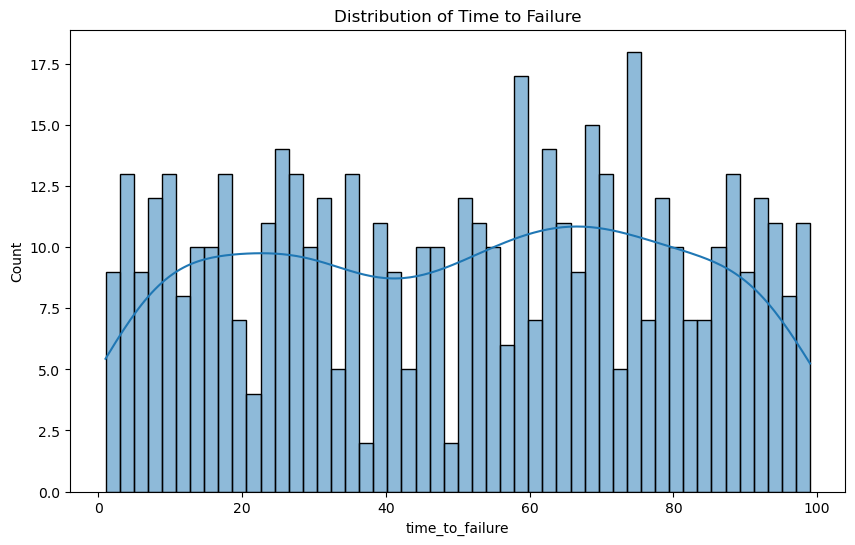

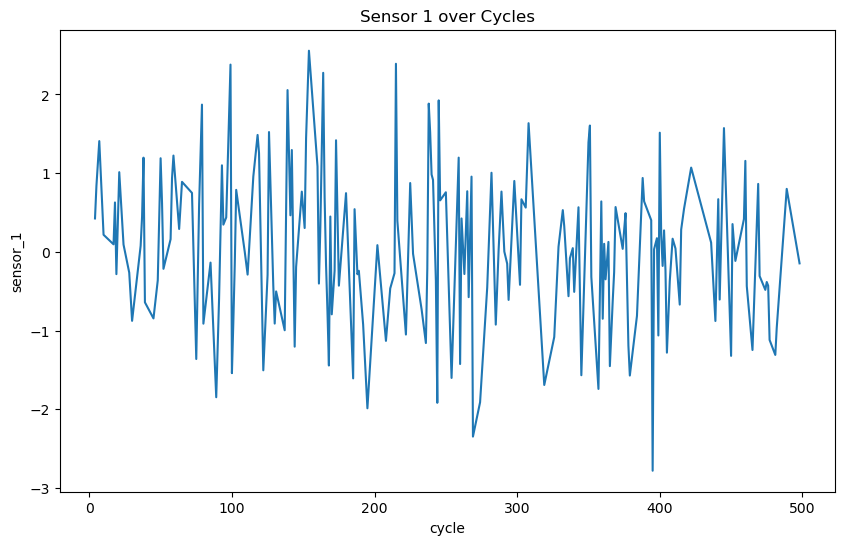

In [12]:
plt.figure(figsize=(10,6))
sns.histplot(df["time_to_failure"], bins=50, kde=True)
plt.title("Distribution of Time to Failure")
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(x="cycle", y="sensor_1", data=df.sample(200))
plt.title("Sensor 1 over Cycles")
plt.show()

In [13]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.drop("failure", axis=1))
X, y = [], []
time_steps = 20
for i in range(len(scaled)-time_steps):
    X.append(scaled[i:i+time_steps])
    y.append(df["failure"].iloc[i+time_steps])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

C:\Users\TAG\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32,
                    validation_split=0.2, verbose=1)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4821 - loss: 0.6997 - val_accuracy: 0.6234 - val_loss: 0.6767
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5049 - loss: 0.6970 - val_accuracy: 0.6234 - val_loss: 0.6818
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5179 - loss: 0.6910 - val_accuracy: 0.6234 - val_loss: 0.6811
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5277 - loss: 0.6915 - val_accuracy: 0.6234 - val_loss: 0.6767
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5179 - loss: 0.6916 - val_accuracy: 0.6234 - val_loss: 0.6715


Test Accuracy: 0.41


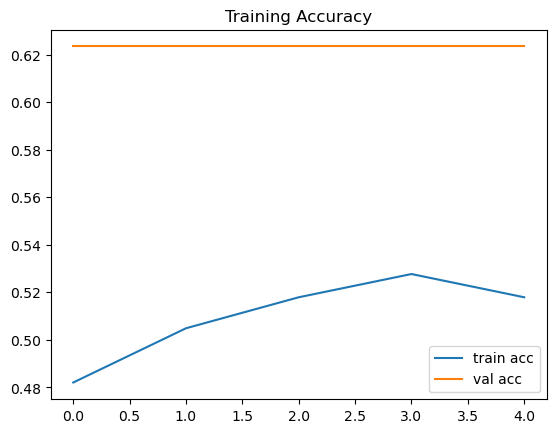

In [16]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.2f}")

plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend()
plt.title("Training Accuracy")
plt.show()